# We use data augmentation with a cnn architecture.

## Image size is 50 and all images are used. Results improve slightly (we would need for epochs and GPUs).

In [1]:
reset -fs

In [2]:
import numpy as np
import pandas as pd
import os
import glob
import pickle
import gzip
import h5py
import dl_functions
from IPython.display import display
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential, model_from_json
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Convolution2D, MaxPooling2D
from keras.optimizers import SGD
from keras.utils import np_utils
from keras.preprocessing.image import array_to_img, img_to_array, load_img
from keras.callbacks import LearningRateScheduler, ModelCheckpoint
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score
from sklearn.cross_validation import train_test_split
from matplotlib import pyplot as plt
%matplotlib inline

Using TensorFlow backend.


#### Loading data from a compressed pickle file that has 20,000 images pre-processed with a size of 50 by 50.

In [3]:
with gzip.open('pre_processed_images/image_data_20000_50.txt.gz', 'rb') as f:
    X, y = pickle.load(f)

In [4]:
datagen = ImageDataGenerator(rotation_range=40,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.4,
    zoom_range=0.1,
    horizontal_flip=False,
    fill_mode='nearest')

#### Creating a train, test split.

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

#### Creating a validation split out of the training set.

In [6]:
X_train_fit, X_val, y_train_fit, y_val = train_test_split(X_train, y_train, test_size=0.3, random_state=42)

#### The labels need to be converted to categorical. Note that we have 2 categories: good (1) and bad (0) images.

In [7]:
y_train_fit_sparse = np_utils.to_categorical(y_train_fit, 2)

In [8]:
y_val_sparse = np_utils.to_categorical(y_val, 2)

In [9]:
y_test_sparse = np_utils.to_categorical(y_test, 2)

In [10]:
datagen.fit(X_train)

#### Creating an instance of a CNN model.

##### The image size is 50.

In [11]:
IMG_SIZE = 50

In [12]:
model_1 = dl_functions.cnn_model_v_1(IMG_SIZE)

In [13]:
model_1.compile(loss='binary_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

In [14]:
model_1.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 48, 48, 32)        896       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 24, 24, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 22, 22, 32)        9248      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 11, 11, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 9, 9, 64)          18496     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 4, 4, 64)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 1024)              0         
__________

In [ ]:
model_1.fit_generator(datagen.flow(X_train_fit, y_train_fit_sparse, batch_size=128), steps_per_epoch=len(X_train_fit), epochs=10, validation_data=(X_val, y_val_sparse))

Epoch 1/10
9800/9800 [==============================] - 2596s - loss: 0.3348 - acc: 0.8571 - val_loss: 0.3518 - val_acc: 0.8669
Epoch 2/10
9800/9800 [==============================] - 2705s - loss: 0.2395 - acc: 0.9049 - val_loss: 0.3636 - val_acc: 0.8664
Epoch 3/10
9800/9800 [==============================] - 2670s - loss: 0.2253 - acc: 0.9138 - val_loss: 0.4068 - val_acc: 0.8710
Epoch 5/10
9800/9800 [==============================] - 2660s - loss: 0.2377 - acc: 0.9095 - val_loss: 0.3514 - val_acc: 0.8810
Epoch 6/10
9800/9800 [==============================] - 2719s - loss: 0.2592 - acc: 0.9024 - val_loss: 0.3812 - val_acc: 0.8840
Epoch 7/10
9800/9800 [==============================] - 2626s - loss: 0.2937 - acc: 0.8891 - val_loss: 0.3500 - val_acc: 0.8764
Epoch 8/10
9800/9800 [==============================] - 2722s - loss: 0.3361 - acc: 0.8712 - val_loss: 0.5208 - val_acc: 0.8245
Epoch 9/10
9800/9800 [==============================] - 2633s - loss: 0.3789 - acc: 0.8520 - val_loss: 0

In [16]:
score = model_1.evaluate(X_test, y_test_sparse, verbose=1)

5952/6000 [============================>.] - ETA: 0s

In [17]:
print('Test loss: {:0,.4f}'.format(score[0]))
print('Test accuracy: {:.2%}'.format(score[1]))

Test loss: 0.4434
Test accuracy: 85.17%


#### Saving model and model weights.

In [18]:
model_1.save('models/model_v1_20000_50_augmentation.h5')

In [19]:
model_1.save_weights('models/model_v1_20000_50_augmentation_weights.h5')

#### Creating a list of predictions.

In [20]:
predicted_images = []
for i in model_1.predict(X_test):
    predicted_images.append(np.where(np.max(i) == i)[0])

#### Displaying a confusion matrix.

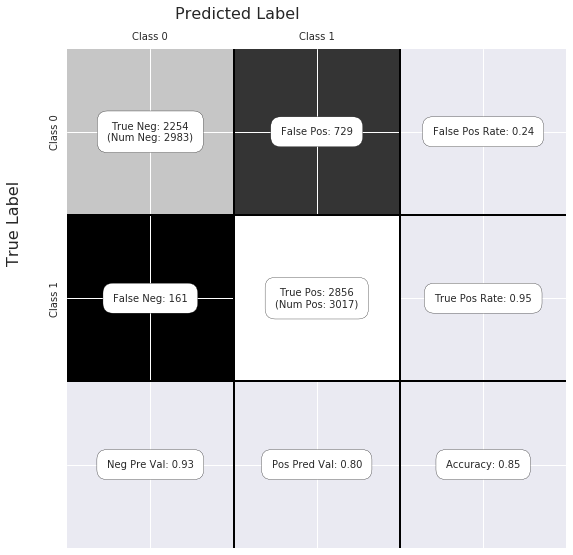

In [21]:
dl_functions.show_confusion_matrix(confusion_matrix(y_test, predicted_images), ['Class 0', 'Class 1'])

#### A more simple confusion matrix using pandas.

In [22]:
pd.DataFrame(confusion_matrix(y_test, predicted_images),columns = ['nok_image','ok_image'])

,nok_image,ok_image
0,2254,729
1,161,2856


#### Area Under the Curve.

In [23]:
print("AUC: {:.2%}\n".format(roc_auc_score(y_test, predicted_images)))

AUC: 85.11%



#### Getting predicted probabilities.

In [24]:
predictions_probability = model_1.predict_proba(X_test)

5952/6000 [============================>.] - ETA: 0s

#### Plotting a ROC curve.

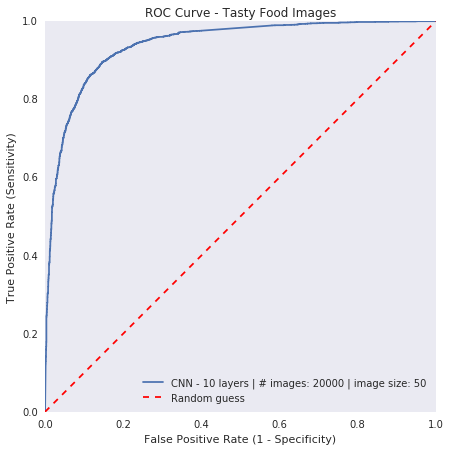

In [25]:
plt.figure(figsize=(7, 7))
dl_functions.plot_roc(y_test, predictions_probability[:,1], "CNN - " + str(len(model_1.layers)) + " layers | # images: " + str(len(X)) + " | image size: " + str(IMG_SIZE), "Tasty Food Images")

### Prediction using an image of Donald Trump.
<img src='images/trump_1.jpg' />

In [26]:
trump = dl_functions.normalize_images_array('images', IMG_SIZE)

In [27]:
trump_prediction = model_1.predict_classes(trump)

1/1 [==============================] - 0s


In [28]:
trump_prediction[0]

0

In [29]:
trump.shape

(1, 50, 50, 3)

In [30]:
trump = trump.reshape(trump.shape[1], trump.shape[2], trump.shape[3])

#### The model predicts the image as bad.

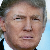

In [31]:
img = array_to_img(trump)
display(img)

#### Copying model and weights to a bucket.

In [32]:
!gsutil cp -r 'models' 'gs://wellio-kadaif-tasty-images-project-pre-processed-images'



Updates are available for some Cloud SDK components.  To install them,
please run:
  $ gcloud components update

Copying file://models/model_v1_20000_25_weights.h5 [Content-Type=application/octet-stream]...
Copying file://models/model_v2_20000_50.h5 [Content-Type=application/octet-stream]...
Copying file://models/model_v1_20000_50_weights.h5 [Content-Type=application/octet-stream]...
Copying file://models/model_v0_20000_25_augmentation_weights.h5 [Content-Type=application/octet-stream]...
\ [4 files][ 15.5 MiB/ 15.5 MiB]                                                
==> NOTE: You are performing a sequence of gsutil operations that may
run significantly faster if you instead use gsutil -m -o ... Please
see the -m section under "gsutil help options" for further information
about when gsutil -m can be advantageous.

Copying file://models/model_v1_20000_100_weights.h5 [Content-Type=application/octet-stream]...
Copying file://models/model_v1_20000_50_augmentation.h5 [Content-Type=applic